In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import os 
sys.path.append(os.path.abspath('../'))
import torch
import functools
import numpy as np
import matplotlib.pyplot as plt 
from IPython.display import clear_output

device = 'cuda'

from convolutions import *
from utils_fns import *
from utils_general import update_sigma_linear, run_scheduler_step, plt_errors, show_with_error
from optimizations import *

# Example Usages

In [3]:
sigma1, sigma2 = 0.1, 0.1

grid_size = 100
x1 = np.linspace(-0.3, 0.3, grid_size)
x2 = np.linspace(-0.3, 0.3, grid_size)
X1, X2 = np.meshgrid(x1, x2)
x = np.stack([X1, X2], axis=2).reshape(-1, 2)
x = torch.tensor(x, dtype=torch.float32).to(device)

# gauss
y = gaussian_nd(x, sigma1).reshape((grid_size,grid_size))

# gauss grad
grad = gauss_grad(x, sigma1)
y0, y1 = grad[:,0].reshape((grid_size,grid_size)), grad[:,1].reshape((grid_size,grid_size))

# gauss hess
hess = gauss_hessian(x, sigma1, device=device)
y00, y01, y11 = hess[:,0,0].reshape((grid_size,grid_size)), hess[:,0,1].reshape((grid_size,grid_size)), hess[:,1,1].reshape((grid_size,grid_size))

In [19]:
# convolution 1D
n_samples = 100
points = torch.tensor([[0.2]]).to(device)
sigma1, sigma2 = 0.1, 0.1
f_args = {'sigma': sigma1}
kernel_args = {'sigma': sigma2}
# usage examples
# 1d
print("Value: ")
sampled_res = convolve(gaussian_nd, gaussian_nd, points, n=n_samples, sampler='uniform', f_args=f_args, kernel_args=kernel_args, sampler_args={}, device=device)

res = gaussian_nd(points[0].unsqueeze(0), sigma=(sigma1**2 + sigma2**2)**0.5)
print("Sampled the convolution result:")
print(sampled_res)

print("True result: ")
print(res)

# gradient kernel with gradient IS
print("\nGrad: ")
sampler = 'importance_gradgauss'
sampler_args = {'sigma':sigma2, 'is_antithetic':True, 'dir':0}
sampled_res = convolve(gaussian_nd, gauss_grad, points,  n=n_samples, sampler=sampler, f_args=f_args, kernel_args=kernel_args, sampler_args=sampler_args, device=device).item()

res = gauss_grad(points[0].unsqueeze(0), sigma=(sigma1**2 + sigma2**2)**0.5)
print("Sampled the convolution result:")
print(sampled_res)

print("True result: ")
print(res)

# Hessian kernel with hessian IS
print("\nHessian: ")
sampler = 'importance_hessgauss'
sampler_args = {'sigma':sigma2, 'is_antithetic':True, 'dir':(0,0)}
sampled_res = convolve(gaussian_nd, gauss_hessian, points,  n=n_samples, sampler=sampler, f_args=f_args, kernel_args=kernel_args, sampler_args=sampler_args, device=device).item()

res = gauss_hessian(points[0].unsqueeze(0), sigma=(sigma1**2 + sigma2**2)**0.5, device=device)
print("Sampled the convolution result:")
print(sampled_res)


print("True result: ")
print(res)


Value: 
Sampled the convolution result:
tensor(1.2636, device='cuda:0')
True result: 
tensor([1.0378], device='cuda:0')

Grad: 
Sampled the convolution result:
-10.310518264770508
True result: 
tensor([[-10.3777]], device='cuda:0')

Hessian: 
Sampled the convolution result:
64.90679168701172
True result: 
tensor([[[51.8884]]], device='cuda:0')


In [23]:
# convolution 2D
n_samples = 100
points = torch.tensor([[0.3, 0.15]]).to(device)
sigma1, sigma2 = 0.1, 0.1
f_args = {'sigma': sigma1}
kernel_args = {'sigma': sigma2}
# usage examples
# 1d
print("Value: ")
sampled_res = convolve(gaussian_nd, gaussian_nd, points, n=n_samples, sampler='uniform', f_args=f_args, kernel_args=kernel_args, sampler_args={}, device=device)

res = gaussian_nd(points[0].unsqueeze(0), sigma=(sigma1**2 + sigma2**2)**0.5)
print("Sampled the convolution result:")
print(sampled_res)

print("True result: ")
print(res)

# gradient kernel with gradient IS
print("\nGrad: ")
sampler = 'importance_gradgauss'
sampler_args = {'sigma':sigma2, 'is_antithetic':True, 'dir':0}
sampled_res0 = convolve(gaussian_nd, gauss_grad, points,  n=n_samples, sampler=sampler, f_args=f_args, kernel_args=kernel_args, sampler_args=sampler_args, device=device)[0].item()
sampler_args = {'sigma':sigma2, 'is_antithetic':True, 'dir':1}
sampled_res1 = convolve(gaussian_nd, gauss_grad, points,  n=n_samples, sampler=sampler, f_args=f_args, kernel_args=kernel_args, sampler_args=sampler_args, device=device)[1].item()

sampled_res = [sampled_res0, sampled_res1]
res = gauss_grad(points[0].unsqueeze(0), sigma=(sigma1**2 + sigma2**2)**0.5)
print("Sampled the convolution result:")
print(sampled_res)

print("True result: ")
print(res)

# Hessian kernel with hessian IS
print("\nHessian: ")
sampler = 'importance_hessgauss'
sampler_args = {'sigma':sigma2, 'is_antithetic':True, 'dir':(0,0)}
sampled_res00 = convolve(gaussian_nd, gauss_hessian, points,  n=n_samples, sampler=sampler, f_args=f_args, kernel_args=kernel_args, sampler_args=sampler_args, device=device)[0,0].item()
sampler_args = {'sigma':sigma2, 'is_antithetic':True, 'dir':(1,1)}
sampled_res11 = convolve(gaussian_nd, gauss_hessian, points,  n=n_samples, sampler=sampler, f_args=f_args, kernel_args=kernel_args, sampler_args=sampler_args, device=device)[1,1].item()
sampler_args = {'sigma':sigma2, 'is_antithetic':True, 'dir':(1,0)}
sampled_res10= convolve(gaussian_nd, gauss_hessian, points,  n=n_samples, sampler=sampler, f_args=f_args, kernel_args=kernel_args, sampler_args=sampler_args, device=device)[1,0].item()

sampled_res = [[sampled_res00, sampled_res10],[sampled_res10, sampled_res11]]

res = gauss_hessian(points[0].unsqueeze(0), sigma=(sigma1**2 + sigma2**2)**0.5, device=device)
print("Sampled the convolution result:")
print(sampled_res)


print("True result: ")
print(res)


Value: 
Sampled the convolution result:
tensor(0.0136, device='cuda:0')
True result: 
tensor([0.4779], device='cuda:0')

Grad: 
Sampled the convolution result:
[-6.931453704833984, -3.3848447799682617]
True result: 
tensor([[-7.1685, -3.5842]], device='cuda:0')

Hessian: 
Sampled the convolution result:
[[70.84205627441406, 46.10491943359375], [46.10491943359375, -5.54265022277832]]
True result: 
tensor([[[83.6325, 53.7637],
         [53.7637,  2.9869]]], device='cuda:0')


# Mse and bias

In [24]:
def variance(samples, gt, axis=0):
    '''
    Calculate the MSE
    samples is nxmxm,
    gt is mxm
    '''
    if axis == 0:
        differences = samples - gt  
    elif axis == 1:
        differences = (samples.T - gt).T
    variances = (differences ** 2).mean(axis=axis)
    return variances

In [25]:
min_sample = 1
add_sample = 30
step = 1
number_of_samples = np.arange(min_sample, min_sample+add_sample, step)
samples_length = len(number_of_samples)

sigma1, sigma2 = 0.1, 0.1
f_args = {'sigma': sigma1}
kernel_args = {'sigma': sigma2}

x = torch.rand(2, device=device)*0.5 - 0.5
x = torch.tensor([0.3, 0.15], requires_grad=True, device=device)
n = 100 # number of iterations for each point

hess_conv_var_uniform = np.zeros((samples_length, 2, 2))
hess_conv_mean_uniform = np.zeros((samples_length, 2, 2))
hess_conv_var_importance = np.zeros((samples_length, 2, 2))
hess_conv_mean_importance = np.zeros((samples_length, 2, 2))
grad_var_uniform = np.zeros((2, samples_length))
grad_mean_uniform = np.zeros((2, samples_length))
grad_var_importance = np.zeros((2, samples_length))
grad_mean_importance = np.zeros((2, samples_length))
for i in tqdm(range(samples_length)):
    distribution_hess_uniform = np.zeros((n,2,2))
    distribution_grad_uniform = np.zeros((2, n))
    hess_importance = np.zeros((n,2,2))
    grad_importance = np.zeros((2, n))
    start_time = time.time()
    for j in range(n):
        # uniform samples
        sampler = 'uniform'
        sampler_args = {'min': -1, 'max': 1}
        convolved_value = convolve(gaussian_nd, gauss_hessian, x.unsqueeze(0), n=number_of_samples[i], sampler=sampler, f_args=f_args, kernel_args=kernel_args, sampler_args=sampler_args, device=device)
        distribution_hess_uniform[j] = convolved_value.detach().cpu().numpy() # hessian
        
        distribution_grad_uniform[:, j] = convolve(gaussian_nd, gauss_grad, x.unsqueeze(0), n=number_of_samples[i],sampler=sampler, 
                                                   f_args=f_args, kernel_args=kernel_args, sampler_args=sampler_args, device=device).cpu().detach().numpy()
        # importance samples
        sampler = 'importance_gradgauss'
        sampler_args = {'sigma': sigma2, 'is_antithetic': True, 'dir':0}
        grad_importance[0, j] = convolve(gaussian_nd, gauss_grad, x.unsqueeze(0), n=number_of_samples[i], sampler=sampler, 
                                         f_args=f_args, kernel_args=kernel_args, sampler_args=sampler_args, device=device).cpu().detach().numpy()[0]
        
        sampler_args = {'sigma': sigma2, 'is_antithetic': True, 'dir':1}
        grad_importance[1, j] = convolve(gaussian_nd, gauss_grad, x.unsqueeze(0), n=number_of_samples[i], sampler=sampler,
                                         f_args=f_args, kernel_args=kernel_args, sampler_args=sampler_args, device=device).cpu().detach().numpy()[1]
        
        sampler = 'importance_hessgauss'
        sampler_args = {'sigma': sigma2, 'is_antithetic': True, 'dir':(0,0)}
        hess_importance[j, 0, 0] = convolve(gaussian_nd, gauss_hessian, x.unsqueeze(0), n=number_of_samples[i], sampler=sampler, 
                                            f_args=f_args, kernel_args=kernel_args, sampler_args=sampler_args, device=device).cpu().detach().numpy()[0,0]
        sampler_args = {'sigma': sigma2, 'is_antithetic': True, 'dir':(1,1)}
        hess_importance[j, 1, 1] = convolve(gaussian_nd, gauss_hessian, x.unsqueeze(0), n=number_of_samples[i], sampler=sampler, 
                                            f_args=f_args, kernel_args=kernel_args, sampler_args=sampler_args, device=device).cpu().detach().numpy()[1,1]
        sampler_args = {'sigma': sigma2, 'is_antithetic': True, 'dir':(1,0)}
        hess_importance[j, 1, 0] = hess_importance[j, 0, 1] = convolve(gaussian_nd, gauss_hessian, x.unsqueeze(0), n=number_of_samples[i], sampler=sampler,
                                                                       f_args=f_args, kernel_args=kernel_args, sampler_args=sampler_args, device=device).cpu().detach().numpy()[1,0]
           
    # print("Number of samples: ", number_of_samples[i])
    # print("Time taken: ", time.time()-start_time)
    hess_conv_mean_uniform[i, :, :] = np.mean(distribution_hess_uniform, axis=0)
    hess_conv_var_uniform[i, :, :] = variance(distribution_hess_uniform, hess_conv_mean_uniform[i,:,:], axis=0)
    hess_conv_mean_importance[i, :, :] = np.mean(hess_importance, axis=0)
    hess_conv_var_importance[i, :, :] = variance(hess_importance, hess_conv_mean_importance[i,:,:], axis=0)
    
    grad_mean_uniform[:, i] = np.mean(distribution_grad_uniform, axis=1)
    grad_var_uniform[:, i] = variance(distribution_grad_uniform, grad_mean_uniform[:,i], axis=1)
    grad_mean_importance[:, i] = np.mean(grad_importance, axis=1)
    grad_var_importance[:, i] = variance(grad_importance, grad_mean_importance[:,i], axis=1)
    


  0%|          | 0/30 [00:00<?, ?it/s]

100%|██████████| 30/30 [00:27<00:00,  1.11it/s]


In [26]:
# compute true grad and hess
new_sigma = (sigma1**2 + sigma2**2)**0.5
diff = gauss_grad(x.clone().detach().unsqueeze(0), new_sigma).cpu().detach().numpy()
true_hess = gauss_hessian(x.clone().detach().unsqueeze(0), new_sigma, device=device).cpu().detach().numpy()
diff = np.tile(diff, (samples_length, 1))
true_hess = np.tile(true_hess, (samples_length, 1, 1))


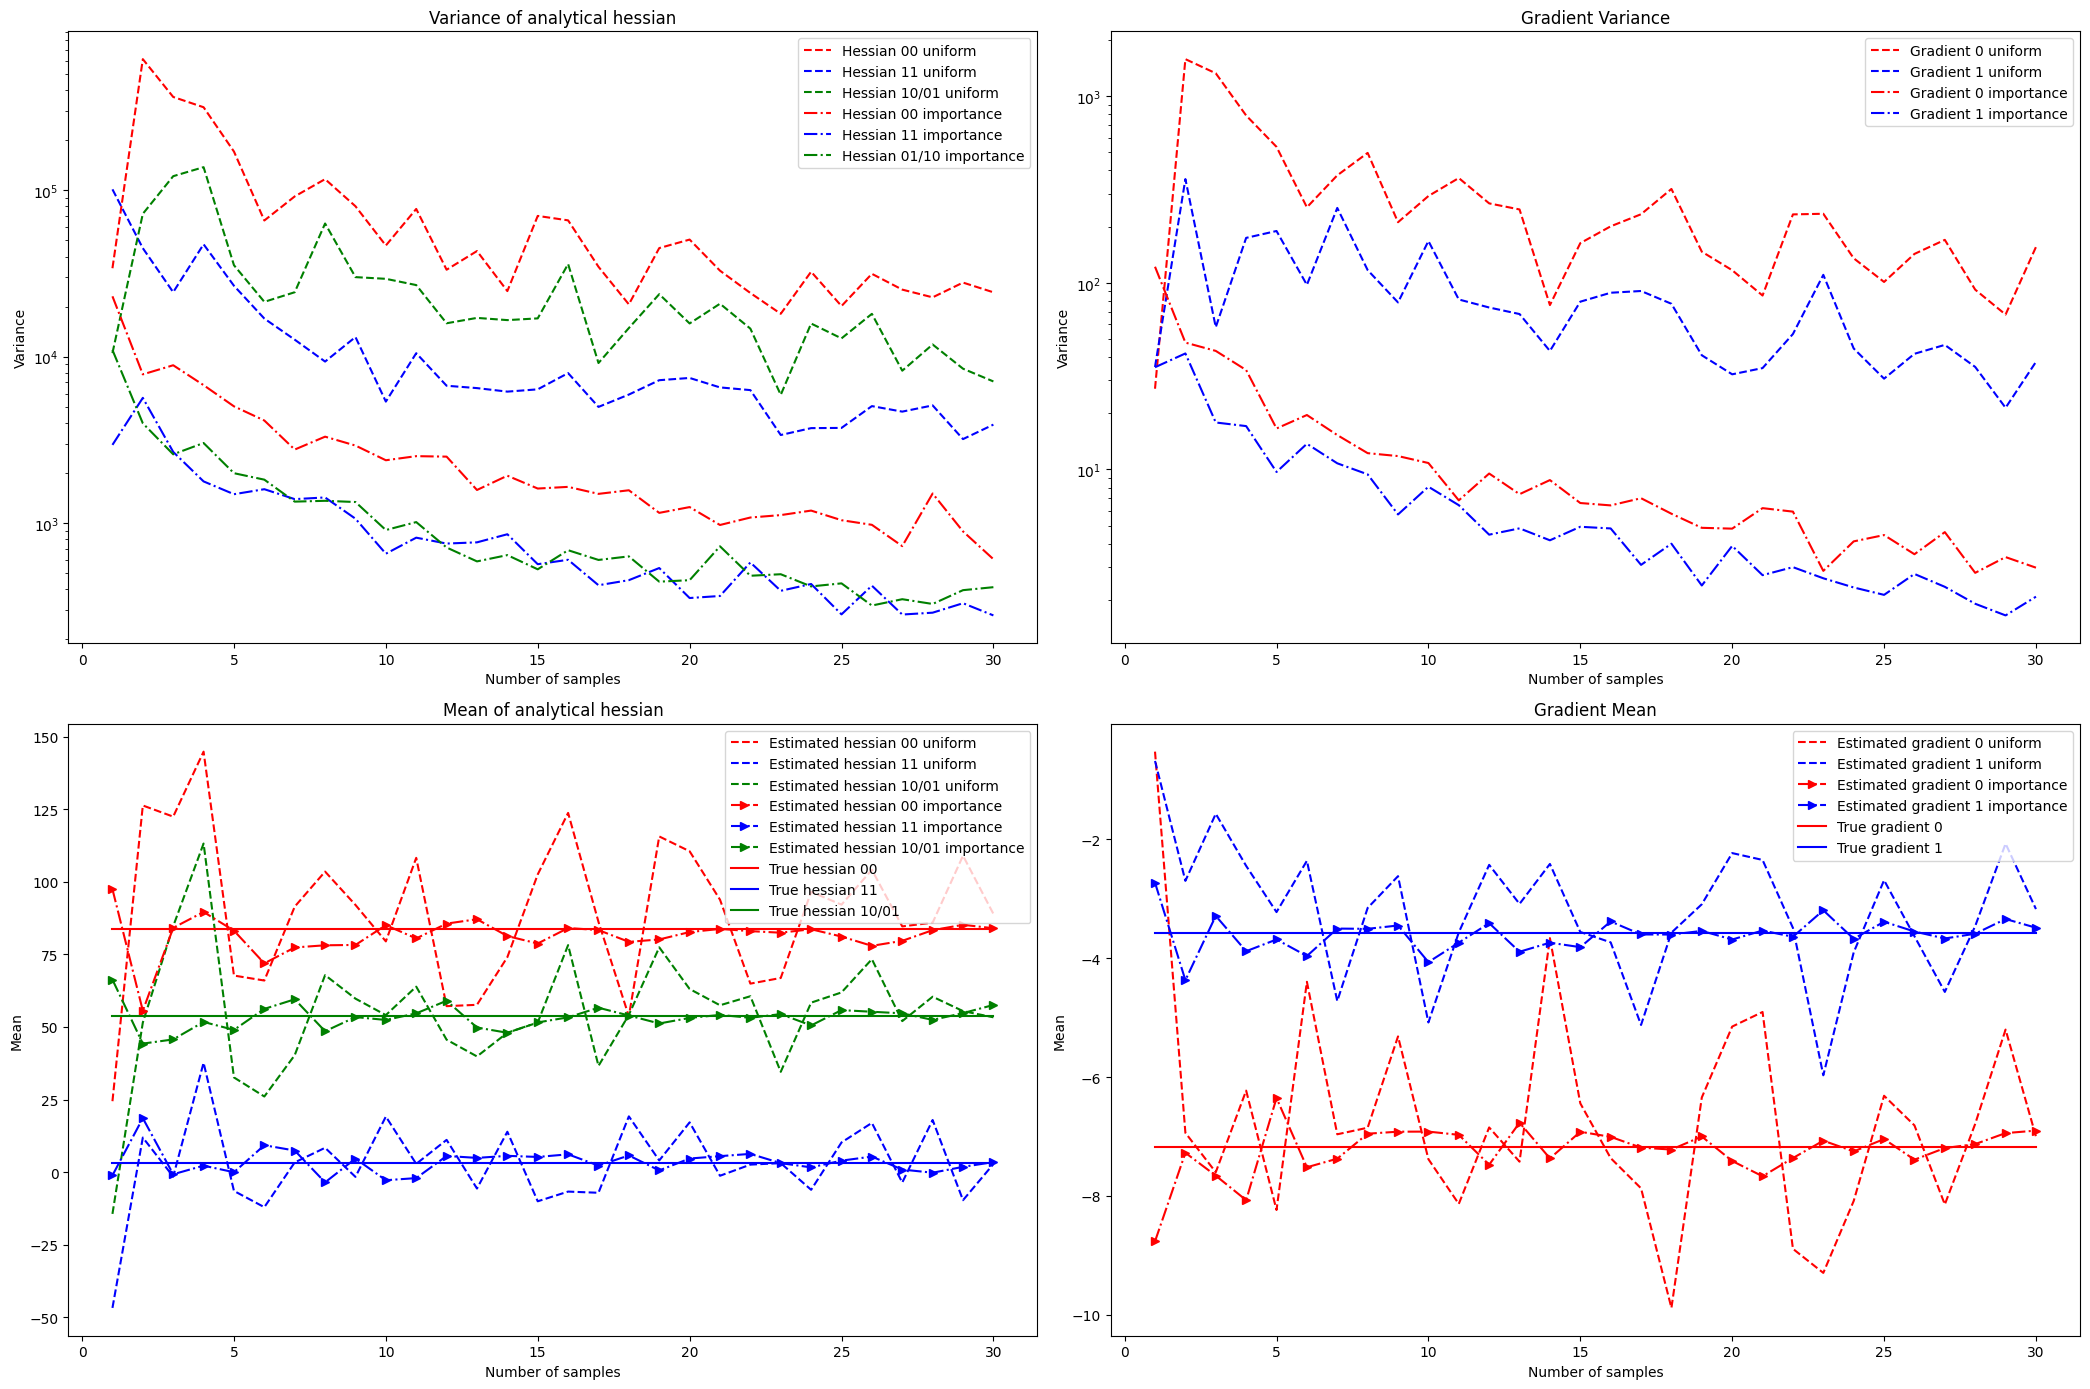

In [27]:
plt.figure(figsize=(21,14))
plt.subplot(2,2,1)
plt.plot(number_of_samples, hess_conv_var_uniform[:,0,0], color='red', linestyle='--', label="Hessian 00 uniform")
plt.plot(number_of_samples, hess_conv_var_uniform[:,1,1], color='blue', linestyle='--', label="Hessian 11 uniform")
plt.plot(number_of_samples, hess_conv_var_uniform[:,1,0], color='green', linestyle='--', label="Hessian 10/01 uniform")
plt.plot(number_of_samples, hess_conv_var_importance[:,0,0], color='red', linestyle='-.', label="Hessian 00 importance")
plt.plot(number_of_samples, hess_conv_var_importance[:,1,1], color='blue', linestyle='-.', label="Hessian 11 importance")
plt.plot(number_of_samples, hess_conv_var_importance[:,0,1], color='green', linestyle='-.', label="Hessian 01/10 importance")
plt.title("Variance of analytical hessian")
plt.xlabel("Number of samples")
plt.yscale('log')
# plt.ylim(bottom=10)
plt.ylabel("Variance")
plt.legend()

plt.subplot(2,2,2)
plt.plot(number_of_samples, grad_var_uniform[0,:], color='red', linestyle='--', label="Gradient 0 uniform")
plt.plot(number_of_samples, grad_var_uniform[1,:], color='blue', linestyle='--', label="Gradient 1 uniform")
plt.plot(number_of_samples, grad_var_importance[0,:], color='red', linestyle='-.', label="Gradient 0 importance")
plt.plot(number_of_samples, grad_var_importance[1,:], color='blue', linestyle='-.', label="Gradient 1 importance")
plt.xlabel("Number of samples")
plt.ylabel("Variance")
plt.yscale('log')
# plt.ylim(bottom=1)
plt.title("Gradient Variance")
plt.legend()

plt.subplot(2,2,3)
plt.plot(number_of_samples, hess_conv_mean_uniform[:,0,0], color='red', linestyle='--', label="Estimated hessian 00 uniform")
plt.plot(number_of_samples, hess_conv_mean_uniform[:,1,1], color='blue', linestyle='--', label="Estimated hessian 11 uniform")
plt.plot(number_of_samples, hess_conv_mean_uniform[:,1,0], color='green', linestyle='--', label="Estimated hessian 10/01 uniform")
plt.plot(number_of_samples, hess_conv_mean_importance[:,0,0], color='red', linestyle='-.', marker='>', label="Estimated hessian 00 importance")
plt.plot(number_of_samples, hess_conv_mean_importance[:,1,1], color='blue', linestyle='-.', marker='>', label="Estimated hessian 11 importance")
plt.plot(number_of_samples, hess_conv_mean_importance[:,1,0], color='green', linestyle='-.', marker='>', label="Estimated hessian 10/01 importance")
plt.plot(number_of_samples, true_hess[:,0,0], color='red', label="True hessian 00")
plt.plot(number_of_samples, true_hess[:,1,1], color='blue', label="True hessian 11")
plt.plot(number_of_samples, true_hess[:,1,0], color='green', label="True hessian 10/01")
plt.plot()
plt.xlabel("Number of samples")
plt.ylabel("Mean")
plt.title("Mean of analytical hessian")
plt.tight_layout()
plt.legend()

plt.subplot(2,2,4)
plt.plot(number_of_samples, grad_mean_uniform[0,:], color='red', linestyle='--', label="Estimated gradient 0 uniform")
plt.plot(number_of_samples, grad_mean_uniform[1,:], color='blue', linestyle='--', label="Estimated gradient 1 uniform")
plt.plot(number_of_samples, grad_mean_importance[0,:], color='red', linestyle='-.', marker='>', label="Estimated gradient 0 importance")
plt.plot(number_of_samples, grad_mean_importance[1,:], color='blue', linestyle='-.', marker='>', label="Estimated gradient 1 importance")
plt.plot(number_of_samples, diff[:,0], color='red', label="True gradient 0")
plt.plot(number_of_samples, diff[:,1], color='blue', label="True gradient 1")
plt.xlabel("Number of samples")
plt.ylabel("Mean")
plt.title("Gradient Mean")
plt.legend()
plt.tight_layout()
plt.show()


# Example problem on parabola

Text(0.5, 1.0, 'Potential function')

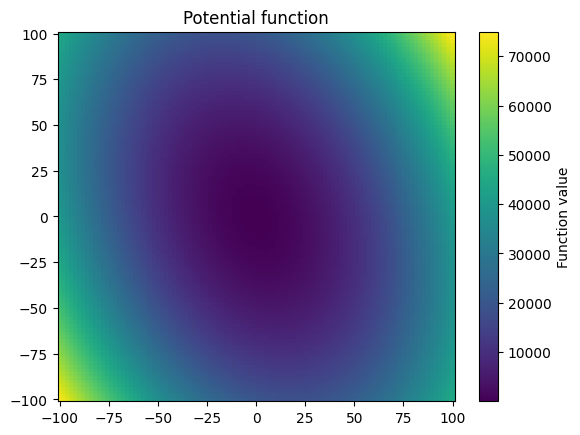

In [87]:
def potential(x, a=1.0, b=1.0, c=1.0):
    '''
    For 2d potential
    x is shape (n, 2)
    '''
    return 0.5*(a*x[:, 0]**2 + b*x[:, 1]**2 + c*x[:, 0]*x[:, 1])

a, b, c = 8.0, 4.0, 3.0

def logging_potential(theta, y_hist, x_hist, i, interval=5):
    y = potential(theta, a, b, c)
    y_hist.append(y)
    x_hist.append(theta)

    if (i+1) % interval == 0:
        print("Iteration: {}, y:{}, x:{}".format(i, y, theta))
    return y_hist, x_hist

grid_size = 100
x1 = np.linspace(-100, 100, grid_size)
x2 = np.linspace(-100, 100, grid_size)
X1, X2 = np.meshgrid(x1, x2)
x = np.stack([X1, X2], axis=2).reshape(-1, 2)
y = potential(torch.tensor(x, dtype=torch.float32), a, b, c).reshape((grid_size,grid_size))

pcm = plt.pcolor(X1, X2, y)
cbar = plt.colorbar(pcm)
cbar.set_label('Function value')
plt.title('Potential function')

In [100]:
n_samples = 10
sigma = 0.1

# plt.rcParams['figure.figsize'] = (12, 6)
ctx_args = {'nsamples':n_samples}
hparams = {'sigma_annealing': False,
           'epochs': 500,
           'anneal_const_first': 200,
           'anneal_const_last': 0,
           'anneal_sigma_min': 0.05,
           'tol': 5e-4, # tolerance for CG
           'NR_max_iter': 200, # max iter for NR line search in CG
           'TR':False,
           'NR_tol': 1e-3, # tolerance for NR line search in CG
           'recompute': 5, # recompute the exact residual every n iterations
           'plot_interval':100 # number of iterations to plot
           }


# --------------- run optimization CG
max_iter = hparams['epochs']
theta = torch.tensor([1.0, -1.0], device=device)
f_args = {'a': a, 'b': b, 'c': c}
kernel_args = {'sigma': sigma}
sampler = 'importance_hessgauss'
sampler_args = {'sigma': sigma, 'is_antithetic': True, 'dir':(0,0)}
start_time = time.time()
x, _, _ = NCG_smooth(potential, theta, max_iter, log_func=logging_potential, f_args=f_args, kernel_args=kernel_args, 
           sampler_args=sampler_args, opt_args=hparams, ctx_args=ctx_args, device=device)
print('Final result: ', x)
print("Time taken: ", time.time()-start_time)


Iteration: 99, y:tensor([1.0270], device='cuda:0'), x:tensor([[ 0.3473, -0.6680]], device='cuda:0')
Converged at  187
Iteration: 186, y:tensor([1.3813e-06], device='cuda:0'), x:tensor([[ 0.0004, -0.0008]], device='cuda:0')
Final result:  tensor([[ 0.0004, -0.0008]], device='cuda:0')
Time taken:  34.32662510871887


In [18]:
hparams = {'sigma_annealing': True,
           'epochs': 10000,
           'anneal_const_first': 200,
           'anneal_const_last': 0,
           'anneal_sigma_min': 0.5,
           'learning_rate':0.2,
           'tol': 1e-7, # tolerance for newton
           'hessian mod':False,
           'plot_interval':100 # number of iterations to plot
           }


# --------------- run optimization newton
max_iter = hparams['epochs']
theta = torch.tensor([100.0, 100.0], device=device)
f_args = {'a': a, 'b': b, 'c': c}
kernel_args = {'sigma': sigma}
sampler = 'importance_hessgauss'
sampler_args = {'sigma': sigma, 'is_antithetic': True, 'dir':(0,0)}
start_time = time.time()
x, _ = newton_smooth(potential, theta, max_iter, log_func=logging_potential, f_args=f_args, kernel_args=kernel_args, 
           sampler_args=sampler_args, opt_args=hparams, ctx_args=ctx_args, device=device)
print('Final result: ', x)
print("Time taken: ", time.time()-start_time)

Iteration: 99, y:tensor([118864.3906], device='cuda:0'), x:tensor([[144.9564,  88.3381]], device='cuda:0')
Iteration: 199, y:tensor([68978.6875], device='cuda:0'), x:tensor([[100.2490,  88.1161]], device='cuda:0')
Iteration: 299, y:tensor([48596.1172], device='cuda:0'), x:tensor([[88.9427, 64.5694]], device='cuda:0')
Iteration: 399, y:tensor([89297.], device='cuda:0'), x:tensor([[123.9219,  80.3943]], device='cuda:0')
Iteration: 499, y:tensor([52219.5156], device='cuda:0'), x:tensor([[ 61.2059, 115.4104]], device='cuda:0')
converged at:  531
Final result:  tensor([[-1.3671e+08,  9.8826e+01]], device='cuda:0')
Time taken:  4.90173864364624


In [101]:
hparams = {'sigma_annealing': True,
           'epochs': 20000,
           'anneal_const_first': 200,
           'anneal_const_last': 0,
           'anneal_sigma_min': 0.5,
           'learning_rate':0.2,
           'tol': 1e-7, # tolerance for newton
           'hessian mod':False,
           'plot_interval':100 # number of iterations to plot
           }

f_args = {'a': a, 'b': b, 'c': c}
kernel_args = {'sigma': sigma}
sampler = 'importance_hessgauss'
sampler_args = {'sigma': sigma, 'is_antithetic': True, 'dir':(0,0)}
# --------------- run optimization Adam
optim = torch.optim.Adam([theta], lr=5e-2)
start_time = time.time()
max_iter = hparams['epochs']
theta = torch.tensor([1.0, -1.0], device=device)
diff_func = smoothFn_gradient(func=potential, sampler='importance_gradgauss', n=n_samples, f_args=f_args,
                        kernel_args=kernel_args, sampler_args=sampler_args, device=device) 
img_errors, param_errors = [], []
for i in range(max_iter):
    optim.zero_grad()
    theta.grad = diff_func(theta.unsqueeze(0)).squeeze(0)
    img_errors, param_errors = logging_potential(theta.unsqueeze(0), img_errors, param_errors, i, interval=1000)
    optim.step()
print('time taken: ', time.time()-start_time)
print('final result: ', theta)

Iteration: 999, y:tensor([4.5000], device='cuda:0'), x:tensor([[ 1., -1.]], device='cuda:0')
Iteration: 1999, y:tensor([4.5000], device='cuda:0'), x:tensor([[ 1., -1.]], device='cuda:0')
Iteration: 2999, y:tensor([4.5000], device='cuda:0'), x:tensor([[ 1., -1.]], device='cuda:0')
Iteration: 3999, y:tensor([4.5000], device='cuda:0'), x:tensor([[ 1., -1.]], device='cuda:0')
Iteration: 4999, y:tensor([4.5000], device='cuda:0'), x:tensor([[ 1., -1.]], device='cuda:0')
Iteration: 5999, y:tensor([4.5000], device='cuda:0'), x:tensor([[ 1., -1.]], device='cuda:0')
Iteration: 6999, y:tensor([4.5000], device='cuda:0'), x:tensor([[ 1., -1.]], device='cuda:0')
Iteration: 7999, y:tensor([4.5000], device='cuda:0'), x:tensor([[ 1., -1.]], device='cuda:0')
Iteration: 8999, y:tensor([4.5000], device='cuda:0'), x:tensor([[ 1., -1.]], device='cuda:0')
Iteration: 9999, y:tensor([4.5000], device='cuda:0'), x:tensor([[ 1., -1.]], device='cuda:0')
time taken:  28.601105213165283
final result:  tensor([ 1., -

# Example problem on box 2D

In [72]:
# From Michael's code box example
def get_rendering(theta, update_fn=None, ctx_args=None): 
  return draw_rect(theta[0], theta[1])


def draw_rect(px, py):   
  s, w, h, exp = 512, 0.07, 0.07, 10
  ss = torch.linspace(0, 1, s, device=device)
  x, y = torch.meshgrid(ss, ss)
  image = 1 - 2*(abs(((py - x)/w))**exp + abs((y - px)/h)**exp)
  return torch.flipud(image.clamp(0, 1)).unsqueeze(-1)


def render_smooth(perturbed_theta, gt_img):
  '''
  Michael's code but without the average image
  '''
  with torch.no_grad():
      imgs, losses = [], []
      for j in range(perturbed_theta.shape[0]):       # for each sample
          perturbed_img = get_rendering(perturbed_theta[j, :])
          perturbed_loss = torch.nn.MSELoss()(perturbed_img, gt_img)
          imgs.append(perturbed_img)
          losses.append(perturbed_loss)
      loss = torch.stack(losses)
  return loss

def logging_box(theta, img_errors, param_errors, i, interval=5, **f_args):
    # plotting, logging, printing...
    theta = theta.squeeze()
    img_curr = get_rendering(theta)
    img_loss = torch.nn.MSELoss()(img_curr, ref_img).item()
    param_loss = torch.nn.MSELoss()(theta, gt_theta).item()
    img_errors.append(img_loss)
    param_errors.append(param_loss)

    print(f"Iter {i+1} - Img.Loss: {img_loss:.4f} - Param.Loss: {param_loss:.4f}")
    if (i+1) % interval == 0: 
        clear_output(wait=True)
        show_with_error(img_curr, ref_img, iter=i+1)
        plt_errors(img_errors, param_errors, title=f'Iter {i+1}')
    return img_errors, param_errors

n_samples = 10
sigma = 0.1

torch.manual_seed(0)

# set up initial and gt translation:
theta = torch.tensor([0.5, 0.6], requires_grad=True, device=device)
gt_theta = torch.tensor([0.3, 0.33], device=device)

init_img = get_rendering(theta)
ref_img = get_rendering(gt_theta)


In [29]:
min_sample = 1
add_sample = 10
sigma = 0.1
x = torch.tensor([0.5, 0.4], requires_grad=True, device=device)
number_of_samples = np.arange(min_sample, min_sample+add_sample, 1)
n = 100
hess_conv_var = np.zeros((add_sample, 2, 2))
hess_conv_mean = np.zeros((add_sample, 2, 2))
grad_conv_var = np.zeros((add_sample, 2))
grad_conv_mean = np.zeros((add_sample, 2))
for i in range(add_sample):
    print("Number of samples: ", number_of_samples[i])
    ctx_args = {'antithetic': True, 'nsamples': number_of_samples[i], 'sigma': sigma,
                'sampler': sampler, 'device': device, 'gt_image': ref_img, 'update_fn': None}
    hess_conv = np.zeros((n,2,2))
    grad_conv = np.zeros((n,2))
    start_time = time.time()
    for j in range(n):
        f_args = {'gt_img': ref_img}
        kernel_args = {'sigma': sigma}
        sampler = 'importance_hessgauss'
        sampler_args = {'sigma': sigma, 'is_antithetic': True, 'dir':(0,0)}
        hess_func = smoothFn_hessian(func=render_smooth, sampler=sampler, n=number_of_samples[i], f_args=f_args,
                                            kernel_args=kernel_args, sampler_args=sampler_args, device=device)
        hess_conv[j,:,:] = hess_func(x.unsqueeze(0)).cpu().detach().numpy()  

        sampler = 'importance_gradgauss'
        grad_func = smoothFn_gradient(func=render_smooth, sampler=sampler, n=number_of_samples[i], f_args=f_args,
                                            kernel_args=kernel_args, sampler_args=sampler_args, device=device) 
        grad_conv[j,:] = grad_func(x.unsqueeze(0)).cpu().detach().numpy()  
    print("Time taken: ", time.time()-start_time)
    hess_conv_var[i, :, :] = np.var(hess_conv, axis=0)
    hess_conv_mean[i, :, :] = np.mean(hess_conv, axis=0)
    grad_conv_var[i,:] = np.var(grad_conv, axis=0)
    grad_conv_mean[i,:] = np.mean(grad_conv, axis=0)


Number of samples:  1
Time taken:  1.0643837451934814
Number of samples:  2
Time taken:  1.2367596626281738
Number of samples:  3
Time taken:  1.459930181503296
Number of samples:  4
Time taken:  1.6915771961212158
Number of samples:  5
Time taken:  1.9336895942687988
Number of samples:  6
Time taken:  2.163804054260254
Number of samples:  7
Time taken:  2.392087697982788
Number of samples:  8
Time taken:  2.6130404472351074
Number of samples:  9
Time taken:  2.855545997619629
Number of samples:  10
Time taken:  3.082075357437134


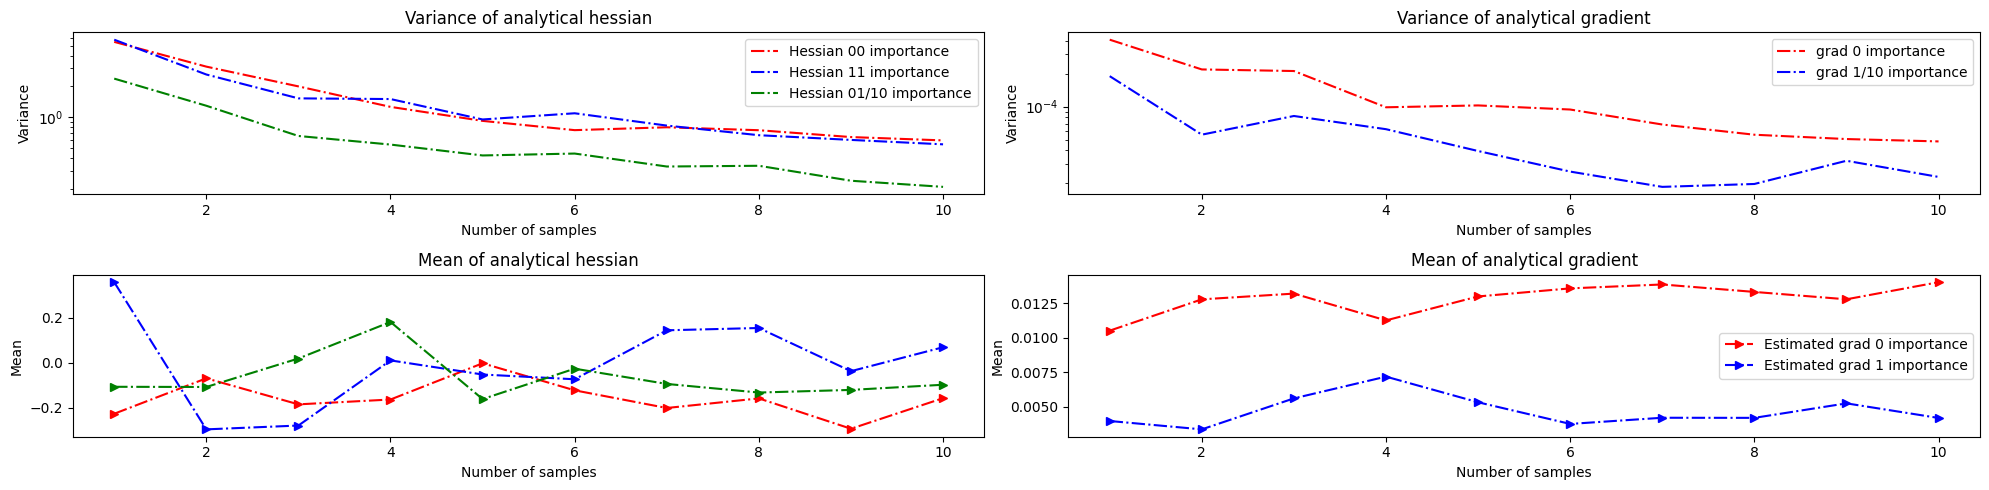

In [30]:
plt.figure(figsize=(20,5))
plt.subplot(2,2,1)
plt.plot(number_of_samples, hess_conv_var[:,0,0], color='red', linestyle='-.', label="Hessian 00 importance")
plt.plot(number_of_samples, hess_conv_var[:,1,1], color='blue', linestyle='-.', label="Hessian 11 importance")
plt.plot(number_of_samples, hess_conv_var[:,0,1], color='green', linestyle='-.', label="Hessian 01/10 importance")
plt.title("Variance of analytical hessian")
plt.xlabel("Number of samples")
plt.yscale('log')
plt.ylabel("Variance")
plt.legend()

plt.subplot(2,2,2)
plt.plot(number_of_samples, grad_conv_var[:,0], color='red', linestyle='-.', label="grad 0 importance")
plt.plot(number_of_samples, grad_conv_var[:,1], color='blue', linestyle='-.', label="grad 1/10 importance")
plt.title("Variance of analytical gradient")
plt.xlabel("Number of samples")
plt.yscale('log')
plt.ylabel("Variance")
plt.legend()

plt.subplot(2,2,3)
plt.plot(number_of_samples, hess_conv_mean[:,0,0], color='red', linestyle='-.', marker='>', label="Estimated hessian 00 importance")
plt.plot(number_of_samples, hess_conv_mean[:,1,1], color='blue', linestyle='-.', marker='>', label="Estimated hessian 11 importance")
plt.plot(number_of_samples, hess_conv_mean[:,1,0], color='green', linestyle='-.', marker='>', label="Estimated hessian 10/01 importance")
plt.plot()
plt.xlabel("Number of samples")
plt.ylabel("Mean")
plt.title("Mean of analytical hessian")

plt.subplot(2,2,4)
plt.plot(number_of_samples, grad_conv_mean[:,0], color='red', linestyle='-.', marker='>', label="Estimated grad 0 importance")
plt.plot(number_of_samples, grad_conv_mean[:,1], color='blue', linestyle='-.', marker='>', label="Estimated grad 1 importance")
plt.plot()
plt.xlabel("Number of samples")
plt.ylabel("Mean")
plt.title("Mean of analytical gradient")
plt.tight_layout()
plt.legend()


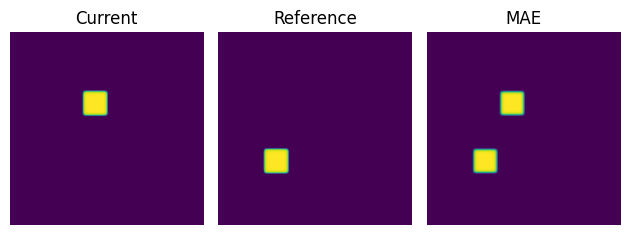

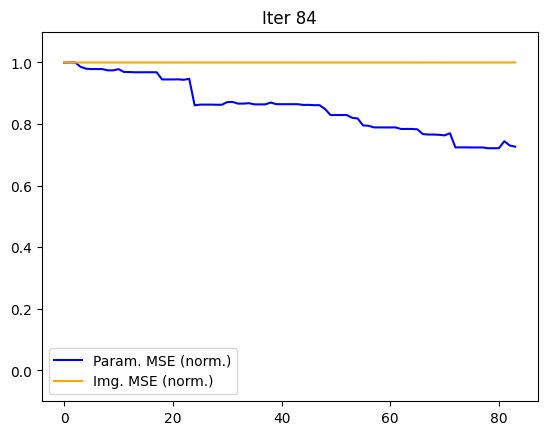

[[0.5        0.66      ]
 [0.49999112 0.66013944]
 [0.4999923  0.6601433 ]
 [0.49646267 0.65906197]
 [0.5008602  0.65502465]
 [0.5017883  0.65416914]
 [0.50178695 0.65416914]
 [0.5017873  0.6541697 ]
 [0.50066113 0.6538955 ]
 [0.5006525  0.65389144]
 [0.500653   0.65480536]
 [0.5006527  0.6526665 ]
 [0.5006527  0.65266633]
 [0.5006588  0.65245014]
 [0.5006577  0.6524895 ]
 [0.5006576  0.6524906 ]
 [0.5006587  0.65248764]
 [0.5006587  0.6524873 ]
 [0.5006392  0.6470624 ]
 [0.5006392  0.6470644 ]
 [0.5006392  0.647064  ]
 [0.5005079  0.6472113 ]
 [0.49998704 0.6472113 ]
 [0.5001486  0.6478831 ]
 [0.47419375 0.642902  ]
 [0.4719208  0.6447277 ]
 [0.47192025 0.6447277 ]
 [0.4719186  0.6447278 ]
 [0.47187436 0.64464545]
 [0.4718749  0.6446461 ]
 [0.46821046 0.6486481 ]
 [0.46815747 0.6487612 ]
 [0.46813542 0.64753276]
 [0.4681359  0.6475324 ]
 [0.4665621  0.6486732 ]
 [0.46637377 0.64786613]
 [0.46637362 0.6478661 ]
 [0.46637404 0.64786536]
 [0.46525648 0.6498468 ]
 [0.46525657 0.64863676]


In [80]:
# plt.rcParams['figure.figsize'] = (12, 6)
n_samples = 10
sigma = 0.1
ctx_args = {'nsamples':n_samples}
hparams = {'sigma_annealing': True,
           'sigma': sigma,
           'epochs': 500,
           'anneal_const_first': 200,
           'anneal_const_last': 0,
           'anneal_sigma_min': 0.01,
           'tol': 1e-3, # tolerance for CG
           'TR':True,
           'TR_rate':0.1,
           'NR_max_iter': 500, # max iter for NR line search in CG
           'NR_tol': 1e-3, # tolerance for NR line search in CG
           'recompute': 20, # recompute the exact residual every n iterations
           'plot_interval':100 # number of iterations to plot
           }


# --------------- run optimization CG
max_iter = hparams['epochs']
theta = torch.tensor([0.5, 0.66], requires_grad=True, device=device)
show_with_error(init_img, ref_img, iter=0)
f_args = {'gt_img': ref_img}
kernel_args = {'sigma': sigma}
sampler = 'importance_hessgauss'
sampler_args = {'sigma': sigma, 'is_antithetic': True, 'dir':(0,0)}
x, _, x_list = NCG_smooth(render_smooth, theta, max_iter, log_func=logging_box, f_args=f_args, kernel_args=kernel_args, 
           sampler_args=sampler_args, opt_args=hparams, ctx_args=ctx_args, device=device)
print(x_list)

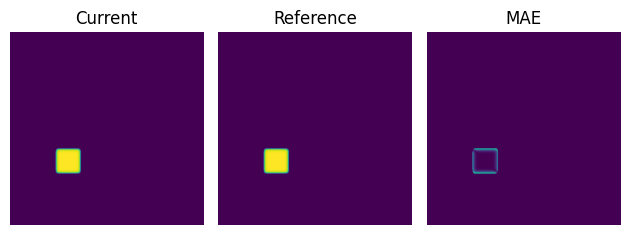

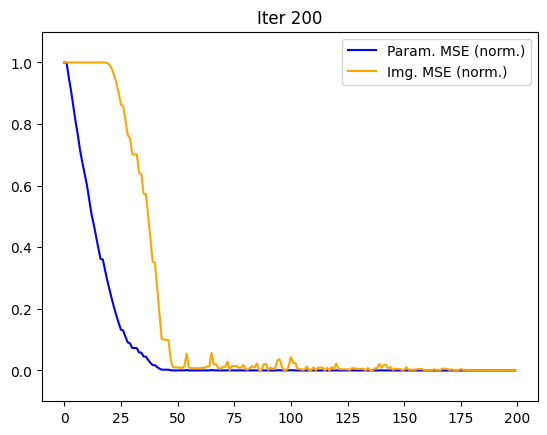

(tensor([[0.2999, 0.3298]], device='cuda:0', grad_fn=<SubBackward0>),
 array([[0.5       , 0.56      ],
        [0.5000002 , 0.549999  ],
        [0.50012624, 0.5497702 ],
        [0.50011957, 0.5398692 ],
        [0.49026856, 0.53986883],
        [0.4807393 , 0.5375769 ],
        [0.47131968, 0.5350564 ],
        [0.47132322, 0.5253554 ],
        [0.46874398, 0.51605546],
        [0.46874183, 0.50645447],
        [0.46873754, 0.49690348],
        [0.46862677, 0.48740312],
        [0.462816  , 0.4799495 ],
        [0.45561993, 0.47390008],
        [0.4462878 , 0.4733064 ],
        [0.4376165 , 0.46994233],
        [0.42913648, 0.466245  ],
        [0.42520842, 0.4579246 ],
        [0.42498213, 0.45741934],
        [0.41985154, 0.44990233],
        [0.41347283, 0.44348106],
        [0.40562087, 0.4390805 ],
        [0.39826855, 0.43397525],
        [0.39274922, 0.4269921 ],
        [0.38551596, 0.4218911 ],
        [0.38084158, 0.41443402],
        [0.3742988 , 0.40862262],
        [0.3

In [86]:
# plt.rcParams['figure.figsize'] = (12, 6)
sigma = 0.1
ctx_args = {'nsamples':n_samples}
hparams = {'sigma_annealing': True,
           'epochs': 200,
           'anneal_const_first': 200,
           'anneal_const_last': 0,
           'anneal_sigma_min': 0.5,
           'learning_rate':0.01,
           'tol': 1e-6, # tolerance for newton
           'hessian mod':True,
           'plot_interval':100 # number of iterations to plot
           }


# --------------- run optimization
max_iter = hparams['epochs']
theta = torch.tensor([0.5, 0.56], requires_grad=True, device=device)
show_with_error(init_img, ref_img, iter=0)
f_args = {'gt_img': ref_img}
kernel_args = {'sigma': sigma}
sampler = 'importance_hessgauss'
sampler_args = {'sigma': sigma, 'is_antithetic': True, 'dir':(0,0)}
newton_smooth(render_smooth, theta, max_iter, log_func=logging_box, f_args=f_args, kernel_args=kernel_args, 
           sampler_args=sampler_args, opt_args=hparams, ctx_args=ctx_args, device=device)
